In [1]:
# Import stuff.

import matplotlib.pyplot as plt
import numpy as np
import time

import seaborn as sns; sns.set()
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.neighbors import KernelDensity

In [2]:
# Read in data.

infile = "res2.out"

# N: Parameter                - KDE bandwidth
# 2: Surface Brightness Ratio - 0.0085360173652
# 3: rA+rB                    - 0.00154688875416
# 4: rB/rA                    - 0.00314488334514
# 5: inc                      - 0.01838043664898004
# 6: Period                   - 2.6496000003817244e-06
# 7eph: Ephemeris             - 0.001731990901753306
# 7: rA                       - 0.00086062193658
# 8: rB                       - 0.00046818878904
# 9: LB/LA                    - 0.00204177077416

data = np.loadtxt(infile,unpack=True,dtype=np.float64,usecols=(9,3,4,5,2))
index = np.where((data[0]<0.2) & (data[2]<=0.8) & (data[3]>=85.0) & (data[0]>0.0001))
print(len(index[0]))
ldata = len(data)
header = ['$L_B / L_A$',
          'r$_B + r_A$',
          '$R_B / R_A$',
          'Inclination',
          'S.Bright Ratio']


18306


In [3]:
# Obtain bandwidths for KDE so it doesn't have to find them more than once...

def get_bandwidth(data,index):

    search = True 
    if search:
        bw = []
        for k in range(len(data)):
            print(f"Starting 1-D KDE: {k+1}/{len(data)}")
            x = data[k][index]
            start = time.time()
            xmin = np.percentile(x,10)
            xmax = np.percentile(x,90)

            lband = (xmax-xmin)/100.
            hband = (xmax-xmin)/10.

            bandwidths = np.linspace(lband,hband,100)
            grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                                {'bandwidth': bandwidths},
                                cv=KFold(n_splits=4))
            grid.fit(x[:, None])
            bw.append(grid.best_params_['bandwidth'])
            print(f"1-D KDE finished: {np.round((time.time()-start)/60,2)} minutes\n{bw[k]}")
    else:
        bw = [0.0045360173652,
              0.00154688875416, 
              0.00314488334514,
              0.01838043664898004,
              2.6496000003817244e-06]
    bw = np.array(bw,dtype=np.float64)
    return(bw)
        

In [4]:
# Define 1-D KDE

def oned_kde(x,bw,k):

    x_d = np.linspace(min(x), max(x), 10000)

    kde = KernelDensity(bandwidth=bw[k], kernel='gaussian')
    kde.fit(x[:,None])
    logprob = kde.score_samples(x_d[:, None])

    return(x_d,np.exp(logprob))

In [5]:
# Define 2-D KDE
# Need to make this 2-D KDE use same bandwidths as 1-D KDE

#def twod_kde(x,y,bw,k,j):
def twod_kde(x,y):

    xmin,xmax = min(x), max(x)
    ymin,ymax = min(y), max(y)

    xx,yy = np.mgrid[xmin:xmax:100j,ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])

    values = np.vstack([x,y])
    kernel = stats.gaussian_kde(values,bw_method='scott')
    f = np.reshape(kernel(positions).T,xx.shape)

    return(xx,yy,f)


Starting 1-D KDE: 1/5
1-D KDE finished: 18.38 minutes
0.001947911539181818
Starting 1-D KDE: 2/5
1-D KDE finished: 18.55 minutes
0.0011900097273636358
Starting 1-D KDE: 3/5
1-D KDE finished: 19.05 minutes
0.003588434633090911
Starting 1-D KDE: 4/5
1-D KDE finished: 18.28 minutes
0.026314127372999964
Starting 1-D KDE: 5/5
1-D KDE finished: 19.36 minutes
0.004853611391090909


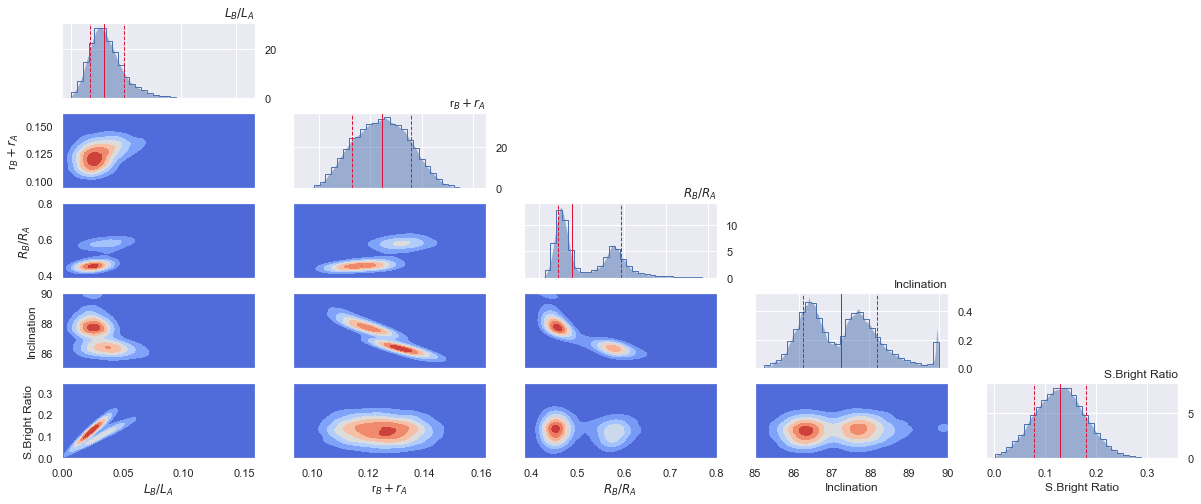

In [6]:
# Create initial plot.
# Visually inspect each. Determine which parameters are multi-peaked.

fig,ax = plt.subplots(nrows=ldata,ncols=ldata,figsize=(20,8))

bw = get_bandwidth(data,index)

for k in range(len(data)):

    x,y = oned_kde(data[k][index],bw,k)


    for j in range(len(data)):
        if j > k:
            fig.delaxes(ax[k,j])
            continue
        else:
            ax[k,j].tick_params(labelbottom=False,labelleft=False)

        if k == j:
            ax[k,j].tick_params(labelright=True)
            ax[k,j].fill_between(x, y, alpha=0.5)
            ax[k,j].hist(data[k][index],histtype="step",bins=30,density=True)
            ax[k,j].set_title(header[k],loc='right')
            ax[k,j].axvline(x=np.percentile(data[k][index],50),color="crimson",linewidth=1)
            ax[k,j].axvline(x=np.percentile(data[k][index],15.87),color="crimson",linestyle="--",linewidth=1)
            ax[k,j].axvline(x=np.percentile(data[k][index],84.13),color="crimson",linestyle="--",linewidth=1)
        if k == len(data)-1:
            ax[k,j].tick_params(labelbottom=True)
            ax[k,j].set_xlabel(header[j])
        if j == 0:
            if k != 0:
                ax[k,j].tick_params(labelleft=True)
                ax[k,j].set_ylabel(header[k])

        if k != j:
            xx,yy,f = twod_kde(data[j][index],data[k][index])
            ax[k,j].contourf(xx,yy,f,cmap='coolwarm',origin='lower')


In [7]:
# Define functions to fit data to for multi-peaked parameters.

from scipy.optimize import curve_fit
from scipy.special import factorial

def double_gauss(x, a1, mu1, sig1, a2, mu2, sig2):
    g = a1*np.exp((-1.0/2.0)*((x-mu1)/sig1)**2.0) + a2*np.exp((-1.0/2.0)*((x-mu2)/sig2)**2.0)
    return(g)

def single_gauss(x, a, mu, sig):
    g = a*np.exp((-1.0/2.0)*((x-mu)/sig)**2.0)
    return(g)

def poisson(x, z):
    p = (z**x)*np.exp(-z)/factorial(x)
    return(p)

def gauss_poisson(x, a, mu, sig, z):
    c = a*np.exp((-1.0/2.0)*((x-mu)/sig)**2.0) + (z**x)*np.exp(-z)/factorial(x)
    return(c)
    

In [8]:
# Fit each peak for each multi-peaked parameter.
# Initial values estimated from initial plot above.

# Define index of multi-peaked distributions.

double_ind = np.array([2,3],dtype=int)

x_d, y_d   = [],[]
popt, pcov = [],[]
for l in double_ind:
    x_d0, y_d0 = oned_kde(data[l][index], bw, double_ind[0]) # x and y values for the kde distribution.
    if l == 2:
        popt0, pcov0 = curve_fit(double_gauss, x_d0, y_d0, p0=[20.0, 0.43, 0.03, 2.5, 0.58, 0.1])
    if l == 3:
        popt0, pcov0 = curve_fit(double_gauss, x_d0, y_d0, p0=[0.2, 85.5, 0.3, 0.5, 87.5, 0.3])
    x_d.append(x_d0)
    y_d.append(y_d0)
    popt.append(popt0)
    pcov.append(pcov0)
 
x_d1, y_d1 = oned_kde(data[double_ind[0]][index], bw, double_ind[0]) # x and y values for the kde distribution.
popt1, pcov1 = curve_fit(double_gauss, x_d1, y_d1, p0=[20.0, 0.43, 0.03, 2.5, 0.58, 0.1])

x_d2, y_d2 = oned_kde(data[double_ind[1]][index], bw, double_ind[1])
popt2, pcov2 = curve_fit(double_gauss, x_d2, y_d2, p0=[0.2, 85.5, 0.3, 0.5, 87.5, 0.3])

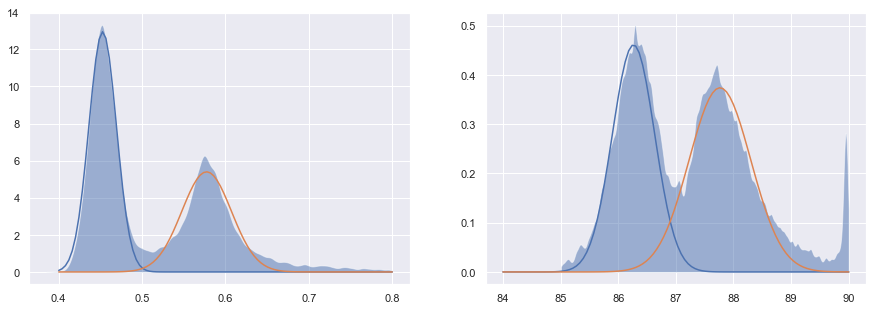

In [9]:
# Still needs to be automated based double_ind[]

# Inspect the fits to each multi-peaked parameter.

fig,ax = plt.subplots(1,2,figsize=(15,5))
x1 = np.linspace(0.4,0.8,100)
y01 = double_gauss(x1,*popt1)
y11 = single_gauss(x1,popt1[0],popt1[1],popt1[2])
y12 = single_gauss(x1,popt1[3],popt1[4],popt1[5])

xd1,yd1 = oned_kde(data[double_ind[0]][index],bw,double_ind[0])

ax[0].fill_between(xd1, yd1, alpha=0.5)
ax[0].plot(x1,y11)
ax[0].plot(x1,y12)
#ax[0].axvline(x=popt1[1],color="crimson")
#ax[0].axvline(x=popt1[2]),color="blue")

x2 = np.linspace(84, 90, 100)
y02 = double_gauss(x2,*popt2)
y21 = single_gauss(x2,popt2[0],popt2[1],popt2[2])
y22 = single_gauss(x2,popt2[3],popt2[4],popt2[5])


xd2,yd2 = oned_kde(data[double_ind[1]][index],bw,double_ind[1])
ax[1].fill_between(xd2, yd2, alpha=0.5)
ax[1].plot(x2,y21)
ax[1].plot(x2,y22)

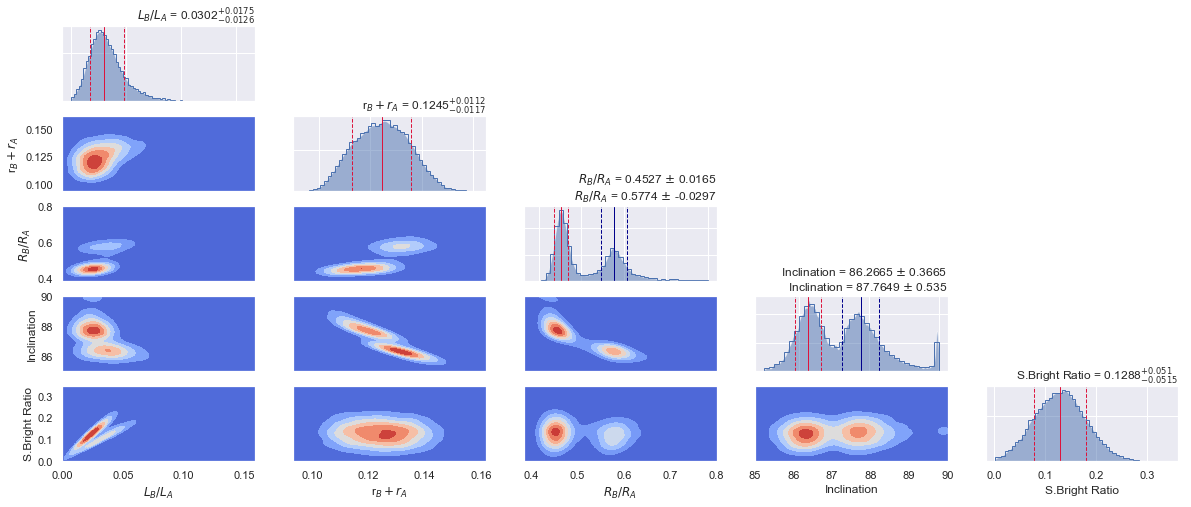

In [10]:
# Create final plot.

fig,ax = plt.subplots(nrows=ldata,ncols=ldata,figsize=(20,8))

for k in range(len(data)):

    x,y = oned_kde(data[k][index],bw,k)


    for j in range(len(data)):
        if j > k:
            fig.delaxes(ax[k,j])
            continue
        else:
            ax[k,j].tick_params(labelbottom=False,labelleft=False)

        if k == j:
            ax[k,j].fill_between(x, y, alpha=0.5)
            ax[k,j].hist(data[k][index],histtype="step",bins='scott',density=True)
            
            if k in double_ind:
                i = np.ravel(np.where(double_ind==k))[0]
                title = str(header[k]) + " = " + str(np.round(popt[i][1],4))  \
                        + " $\pm$ " + str(np.round(popt[i][2],4)) + "\n" +    \
                        str(header[k]) + " = " + str(np.round(popt[i][4],4))  \
                        + " $\pm$ " + str(np.round(popt[i][5],4))
                ax[k,j].set_title(title,loc='right')

                ax[k,j].axvline(x=popt[i][1],color="crimson",linewidth=1)
                ax[k,j].axvline(x=popt[i][1]+popt[i][2],color="crimson",linestyle="--",linewidth=1)
                ax[k,j].axvline(x=popt[i][1]-popt[i][2],color="crimson",linestyle="--",linewidth=1)
                ax[k,j].axvline(x=popt[i][4],color="darkblue",linewidth=1)
                ax[k,j].axvline(x=popt[i][4]+popt[i][5],color="darkblue",linestyle="--",linewidth=1)
                ax[k,j].axvline(x=popt[i][4]-popt[i][5],color="darkblue",linestyle="--",linewidth=1)
            
            else:
                fifty     = np.percentile(data[k][index],50)
                onesigup  = np.percentile(data[k][index],84.13) - fifty
                onesigdwn = fifty - np.percentile(data[k][index],15.87)
                
                title = str(header[k]) + " = " + str(np.round(fifty,4))  \
                        + "$^{+" + str(np.round(onesigup,4)) + "}_{-"    \
                        + str(np.round(onesigdwn,4)) + "}$"
                ax[k,j].set_title(title,loc='right')
              
                ax[k,j].axvline(x=np.percentile(data[k][index],50),color="crimson",linewidth=1)
                ax[k,j].axvline(x=np.percentile(data[k][index],15.87),color="crimson",linestyle="--",linewidth=1)
                ax[k,j].axvline(x=np.percentile(data[k][index],84.13),color="crimson",linestyle="--",linewidth=1)
         
        if k == len(data)-1:
            ax[k,j].tick_params(labelbottom=True)
            ax[k,j].set_xlabel(header[j])
        if j == 0:
            if k != 0:
                ax[k,j].tick_params(labelleft=True)
                ax[k,j].set_ylabel(header[k])

        if k != j:
            xx,yy,f = twod_kde(data[j][index],data[k][index])
            ax[k,j].contourf(xx,yy,f,cmap='coolwarm',origin='lower')

plt.savefig("jktebop_corner.pdf")